In [ ]:
from google.colab import drive
import os
import glob
import pandas as pd

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/data-science-veiculos-poluicao'
os.chdir(folder_path)

print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['senatran', 'iema', 'iema-agg', 'senatran-agg', 'cidades_lookup.csv', 'detran', 'ARQUIVO', 'anp', 'combustiveis.csv', 'combustiveis.ipynb', 'idades_veiculos_anual.csv', 'ano_modelo.ipynb', 'poluentes_anual.csv', 'iema-2.ipynb', 'panel_idade_poluicao_combusteiveis.ipynb', 'panel_idade_poluicao_combusteiveis_2.ipynb', 'age_10_25.csv', 'ano_modelo_2.ipynb', 'age_5_30.csv', 'idades_veiculos_anual_agg.csv', 'ano_modelo_3.ipynb', 'panel_idade_poluicao_combusteiveis_3.ipynb']


In [ ]:
poluentes_df = pd.read_csv('poluentes_anual.csv')
idades_df = pd.read_csv('idades_veiculos_anual_agg.csv')
combustiveis_df = pd.read_csv('combustiveis.csv')

print("Head of poluentes_df:")
display(poluentes_df.head())

print("\nHead of idades_df:")
display(idades_df.head())

print("\nHead of combustiveis_df:")
display(combustiveis_df.head())

Head of poluentes_df:


,Unnamed: 0,cidade,ano,CO,FMC,MP10,MP2.5,NO,NO2,O3,PTS,SO2
0,0,AMERICANA,2015,NaN,NaN,28.969444,NaN,NaN,NaN,22.457971,NaN,NaN
1,1,AMERICANA,2016,NaN,NaN,25.913889,NaN,NaN,NaN,39.695946,NaN,NaN
2,2,AMERICANA,2017,NaN,NaN,26.327778,NaN,NaN,NaN,53.165217,NaN,NaN
3,3,AMERICANA,2018,NaN,NaN,27.757660,NaN,NaN,NaN,57.604651,NaN,NaN
4,4,AMERICANA,2019,NaN,NaN,17.991304,NaN,NaN,NaN,53.894260,NaN,NaN



Head of idades_df:


,cidade,ano,0a5,5a10,10a20,acima20
0,AMERICANA,2015,40264.0,44398.0,44863.0,35803.0
1,AMERICANA,2016,35555.0,46784.0,46982.0,39742.0
2,AMERICANA,2017,32184.0,46101.0,50721.0,44227.0
3,AMERICANA,2018,29066.0,45787.0,55847.0,47402.0
4,AMERICANA,2019,28162.0,44929.0,60036.0,49984.0



Head of combustiveis_df:


,cidade,ano,gasolina,diesel,etanol
0,AMERICANA,2015,60512400.0,69038912.0,83800000.0
1,AMERICANA,2016,66521022.0,68943735.0,75242800.0
2,AMERICANA,2017,76911731.0,72859597.0,66771836.0
3,AMERICANA,2018,54104808.0,85675593.0,80498487.0
4,AMERICANA,2019,49384500.0,93079700.0,89251290.0


In [ ]:
merged_df = pd.merge(combustiveis_df, idades_df, on=['cidade', 'ano'])

display(merged_df.head())

,cidade,ano,gasolina,diesel,etanol,0a5,5a10,10a20,acima20
0,AMERICANA,2015,60512400.0,69038912.0,83800000.0,40264.0,44398.0,44863.0,35803.0
1,AMERICANA,2016,66521022.0,68943735.0,75242800.0,35555.0,46784.0,46982.0,39742.0
2,AMERICANA,2017,76911731.0,72859597.0,66771836.0,32184.0,46101.0,50721.0,44227.0
3,AMERICANA,2018,54104808.0,85675593.0,80498487.0,29066.0,45787.0,55847.0,47402.0
4,AMERICANA,2019,49384500.0,93079700.0,89251290.0,28162.0,44929.0,60036.0,49984.0


# Função para preparar o dataset antes das regressões

In [ ]:
def prepare_pollutant_data(df, pollutant):
  df_pollutant = pd.merge(merged_df, poluentes_df.dropna(subset=[pollutant])[['cidade', 'ano', pollutant]], on=['cidade', 'ano'], how='inner')

  # Adicionar uma coluna para indicar se o ano é durante a COVID-19
  df_pollutant['covid19'] = df_pollutant['ano'].apply(lambda x: 1 if x in [2020, 2021] else 0)

  return df_pollutant

# Funções de regressão OLS e LSDV

In [ ]:
import statsmodels.api as sm

def run_ols_regression(df_pollutant, pollutant):

  # Definir as variáveis dependente e independentes
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]

  # Adicionar uma constante às variáveis independentes
  independent_vars = sm.add_constant(independent_vars)

  # Ajustar o modelo OLS agrupado
  pooled_ols_model = sm.OLS(dependent_var, independent_vars).fit()

  # Imprimir o resumo da regressão
  print(pooled_ols_model.summary())

In [ ]:
def run_lsdv_regression(df_pollutant, pollutant):

  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]

  # Criar variáveis dummy para 'cidade'
  city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)

  # Concatenar as variáveis dummy com as variáveis independentes
  independent_vars_fe = pd.concat([independent_vars, city_dummies], axis=1)

  # Converter colunas relevantes para numéricas, tratando erros, e converter explicitamente booleanos para int
  for col in independent_vars_fe.columns:
      if independent_vars_fe[col].dtype == 'object':
          independent_vars_fe[col] = pd.to_numeric(independent_vars_fe[col], errors='coerce')
      elif pd.api.types.is_bool_dtype(independent_vars_fe[col]):
          independent_vars_fe[col] = independent_vars_fe[col].astype(int)

  # Ajustar o modelo OLS de efeitos fixos (abordagem LSDV) novamente
  fixed_effects_model = sm.OLS(dependent_var, independent_vars_fe).fit()

  # Imprimir o resumo da regressão
  print(fixed_effects_model.summary())

## Interação por poluentes

(CO, FMC, MP2.5, NO, NO2, O3, PTS, SO2)

In [ ]:
pollutants_to_analyze = ['CO', 'FMC', 'MP10', 'MP2.5', 'NO', 'NO2', 'O3', 'PTS', 'SO2']

for pollutant in pollutants_to_analyze:
    print(f"\n\nRunning regression for pollutant: {pollutant}")

    # Prepare pollutant data
    df_pollutant = prepare_pollutant_data(merged_df, pollutant)

    # Check if there are enough observations for regression (e.g., more than the number of independent variables + cities)
    if df_pollutant.shape[0] > (15 + df_pollutant['cidade'].nunique()):
        print(f"\nOLS Regression for {pollutant}:")
        run_ols_regression(df_pollutant, pollutant)

        print(f"\nLSDV Regression for {pollutant}:")
        run_lsdv_regression(df_pollutant, pollutant)
    else:
        print(f"Insufficient data for pollutant: {pollutant}. Skipping regression.")



Running regression for pollutant: CO

OLS Regression for CO:
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     4.746
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           0.000163
Time:                        04:59:01   Log-Likelihood:                -461.25
No. Observations:                  67   AIC:                             940.5
Df Residuals:                      58   BIC:                             960.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

## Novas regressões, sistematicamente passando por todos os poluentes

Funções defininas novamente, de forma mais enxuta e com for para os poluentes


In [ ]:
import statsmodels.api as sm

def run_ols_regression_return_summary(df_pollutant, pollutant):
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
  independent_vars = sm.add_constant(independent_vars)
  pooled_ols_model = sm.OLS(dependent_var, independent_vars).fit()
  return pooled_ols_model.summary()

def run_lsdv_regression_return_summary(df_pollutant, pollutant):
  dependent_var = df_pollutant[pollutant]
  independent_vars = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
  city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)
  independent_vars_fe = pd.concat([independent_vars, city_dummies], axis=1)

  for col in independent_vars_fe.columns:
      if independent_vars_fe[col].dtype == 'object':
          independent_vars_fe[col] = pd.to_numeric(independent_vars_fe[col], errors='coerce')
      elif pd.api.types.is_bool_dtype(independent_vars_fe[col]):
          independent_vars_fe[col] = independent_vars_fe[col].astype(int)

  fixed_effects_model = sm.OLS(dependent_var, independent_vars_fe).fit()
  return fixed_effects_model.summary()

pollutants_to_analyze = ['CO', 'FMC', 'MP10', 'MP2.5', 'NO', 'NO2', 'O3', 'PTS', 'SO2']
regression_results = {}

for pollutant in pollutants_to_analyze:
    print(f"Processing pollutant: {pollutant}")
    df_pollutant = prepare_pollutant_data(merged_df, pollutant)

    if df_pollutant.shape[0] > (15 + df_pollutant['cidade'].nunique()):
        regression_results[pollutant] = {}

        ols_summary = run_ols_regression_return_summary(df_pollutant, pollutant)
        lsdv_summary = run_lsdv_regression_return_summary(df_pollutant, pollutant)

        # Extrair coeficientes e p-valores do resumo OLS
        ols_table = ols_summary.tables[1]
        ols_data = pd.DataFrame(ols_table.data[1:], columns=ols_table.data[0])
        ols_data = ols_data[['', 'coef', 'P>|t|']].rename(columns={'': 'variable'})
        ols_data['coef'] = pd.to_numeric(ols_data['coef'], errors='coerce')
        ols_data['P>|t|'] = pd.to_numeric(ols_data['P>|t|'], errors='coerce')
        regression_results[pollutant]['OLS'] = {
            'results': ols_data.to_dict(orient='records'),
            'r_squared': float(ols_summary.tables[0].data[0][3]) # Extrair R-quadrado
        }


        # Extrair coeficientes e p-valores do resumo LSDV
        lsdv_table = lsdv_summary.tables[1]
        lsdv_data = pd.DataFrame(lsdv_table.data[1:], columns=lsdv_table.data[0])
        lsdv_data = lsdv_data[['', 'coef', 'P>|t|']].rename(columns={'': 'variable'})
        lsdv_data['coef'] = pd.to_numeric(lsdv_data['coef'], errors='coerce')
        lsdv_data['P>|t|'] = pd.to_numeric(lsdv_data['P>|t|'], errors='coerce')
        regression_results[pollutant]['LSDV'] = {
            'results': lsdv_data.to_dict(orient='records'),
            'r_squared': float(lsdv_summary.tables[0].data[0][3]) # Extrair R-quadrado
        }

    else:
        print(f"Insufficient data for pollutant: {pollutant}. Skipping regression.")

Processing pollutant: CO
Processing pollutant: FMC
Insufficient data for pollutant: FMC. Skipping regression.
Processing pollutant: MP10
Processing pollutant: MP2.5
Processing pollutant: NO
Insufficient data for pollutant: NO. Skipping regression.
Processing pollutant: NO2
Processing pollutant: O3
Processing pollutant: PTS
Processing pollutant: SO2


## Organização dos resultados


In [ ]:
import pandas as pd

all_results_df = pd.DataFrame()

for pollutant, models in regression_results.items():
    for model_type, results_dict in models.items():
        temp_df = pd.DataFrame(results_dict['results'])
        temp_df['pollutant'] = pollutant
        temp_df['model'] = model_type
        temp_df['r_squared'] = results_dict['r_squared'] # Adicionar R^2
        all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)

all_results_df = all_results_df.reset_index(drop=True)

display(all_results_df.head(50))

,variable,coef,P>|t|,pollutant,model,r_squared
0,const,6.370615e+02,0.000,CO,OLS,0.396
1,gasolina,8.102000e-07,0.214,CO,OLS,0.396
2,diesel,-3.163000e-06,0.001,CO,OLS,0.396
3,etanol,3.011000e-07,0.557,CO,OLS,0.396
4,0a5,-2.200000e-03,0.166,CO,OLS,0.396
5,5a10,2.600000e-03,0.013,CO,OLS,0.396
6,10a20,6.600000e-03,0.010,CO,OLS,0.396
7,acima20,-5.400000e-03,0.013,CO,OLS,0.396
8,covid19,-1.423930e+02,0.091,CO,OLS,0.396
9,gasolina,-1.703000e-07,0.759,CO,LSDV,0.970


Comparação dos R^2

In [ ]:
import pandas as pd

# Criar uma lista de dicionários para armazenar os valores de R-quadrado
r_squared_data = []

for pollutant, models in regression_results.items():
    r_squared_entry = {'pollutant': pollutant}
    if 'OLS' in models and 'r_squared' in models['OLS']:
        r_squared_entry['OLS-R2 values'] = models['OLS']['r_squared']
    else:
        r_squared_entry['OLS-R2 values'] = None # Ou np.nan

    if 'LSDV' in models and 'r_squared' in models['LSDV']:
        r_squared_entry['LSDV-R2 values'] = models['LSDV']['r_squared']
    else:
        r_squared_entry['LSDV-R2 values'] = None # Ou np.nan

    r_squared_data.append(r_squared_entry)

# Criar um DataFrame a partir da lista de dicionários
r_squared_df = pd.DataFrame(r_squared_data)

# Exibir o DataFrame
display(r_squared_df)

,pollutant,OLS-R2 values,LSDV-R2 values
0,CO,0.396,0.970
1,MP10,0.127,0.958
2,MP2.5,0.346,0.961
3,NO2,0.417,0.969
4,O3,0.101,0.980
5,PTS,0.407,0.657
6,SO2,0.296,0.812


## Criação de gráficos

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar para incluir apenas variáveis de tipo de combustível e idade do veículo
variables_to_include = ['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']
filtered_results_df = all_results_df[all_results_df['variable'].isin(variables_to_include)].copy()

display(filtered_results_df.head())

,variable,coef,P>|t|,pollutant,model,r_squared
1,gasolina,8.102000e-07,0.214,CO,OLS,0.396
2,diesel,-3.163000e-06,0.001,CO,OLS,0.396
3,etanol,3.011000e-07,0.557,CO,OLS,0.396
4,0a5,-2.200000e-03,0.166,CO,OLS,0.396
5,5a10,2.600000e-03,0.013,CO,OLS,0.396


# Correlação positiva ou negativa

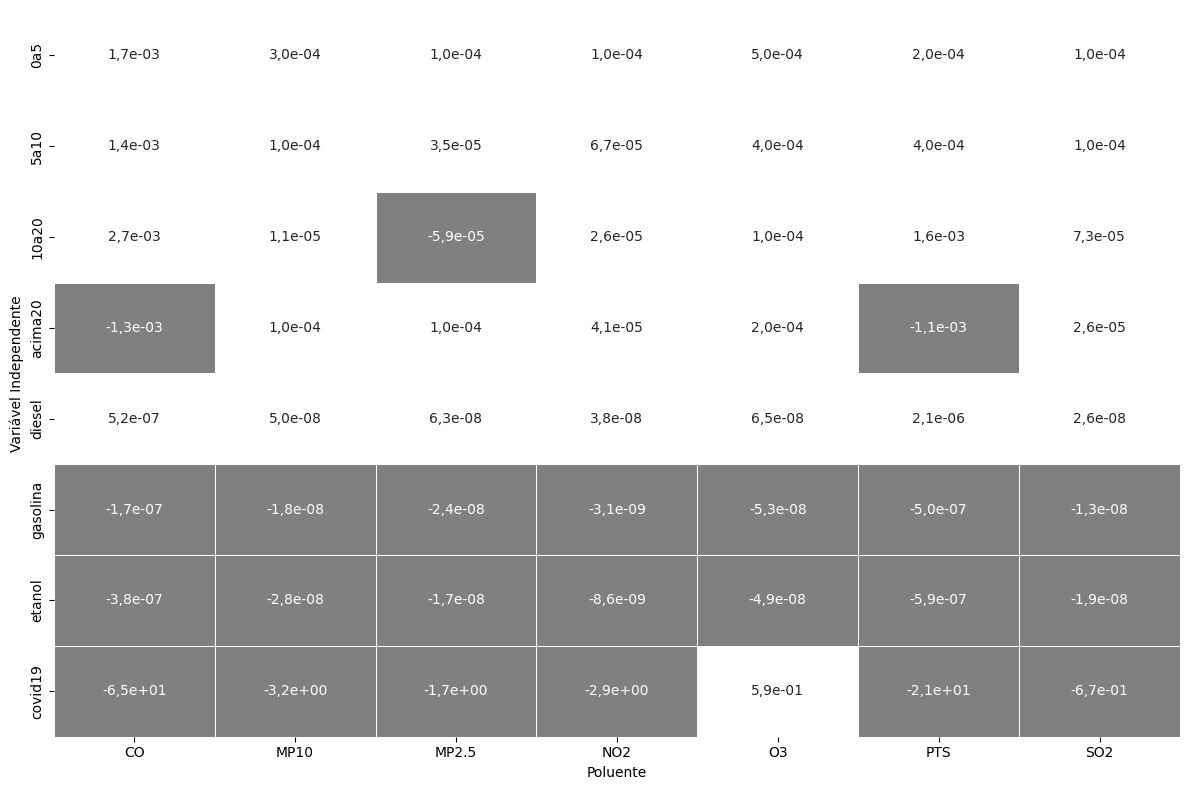

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir a ordem desejada das variáveis
variable_order = ['0a5', '5a10', '10a20', 'acima20', 'diesel', 'gasolina', 'etanol', 'covid19']

# Plotar para o Modelo LSDV
lsdv_results_df = filtered_results_df[filtered_results_df['model'] == 'LSDV'].copy()

# Criar tabela dinâmica e reindexar para aplicar a ordem desejada
lsdv_pivot_coef = lsdv_results_df.pivot_table(index='variable', columns='pollutant', values='coef')
lsdv_pivot_coef = lsdv_pivot_coef.reindex(variable_order)

# Format the annotations with comma as decimal separator
annot_data = lsdv_pivot_coef.map(lambda x: f'{x:.1e}'.replace('.', ',')) # Use map instead of applymap

# Usar um mapa de cores personalizado: branco para positivo (1), cinza para negativo (0)
cmap = sns.color_palette(['grey', 'white'])

plt.figure(figsize=(12, 8))
# Usar lsdv_pivot_coef for coloring and annot_data for annotations
sns.heatmap(lsdv_pivot_coef > 0, annot=annot_data, cmap=cmap, fmt='s', linewidths=.5, cbar=False, annot_kws={'fontsize': 10}) # Use fmt='s' to display strings
#plt.title('Sinal dos Coeficientes do Modelo LSDV (Branco: Positivo, Cinza: Negativo)')
plt.xlabel('Poluente')
plt.ylabel('Variável Independente')
plt.tight_layout()
plt.show()

## Significância

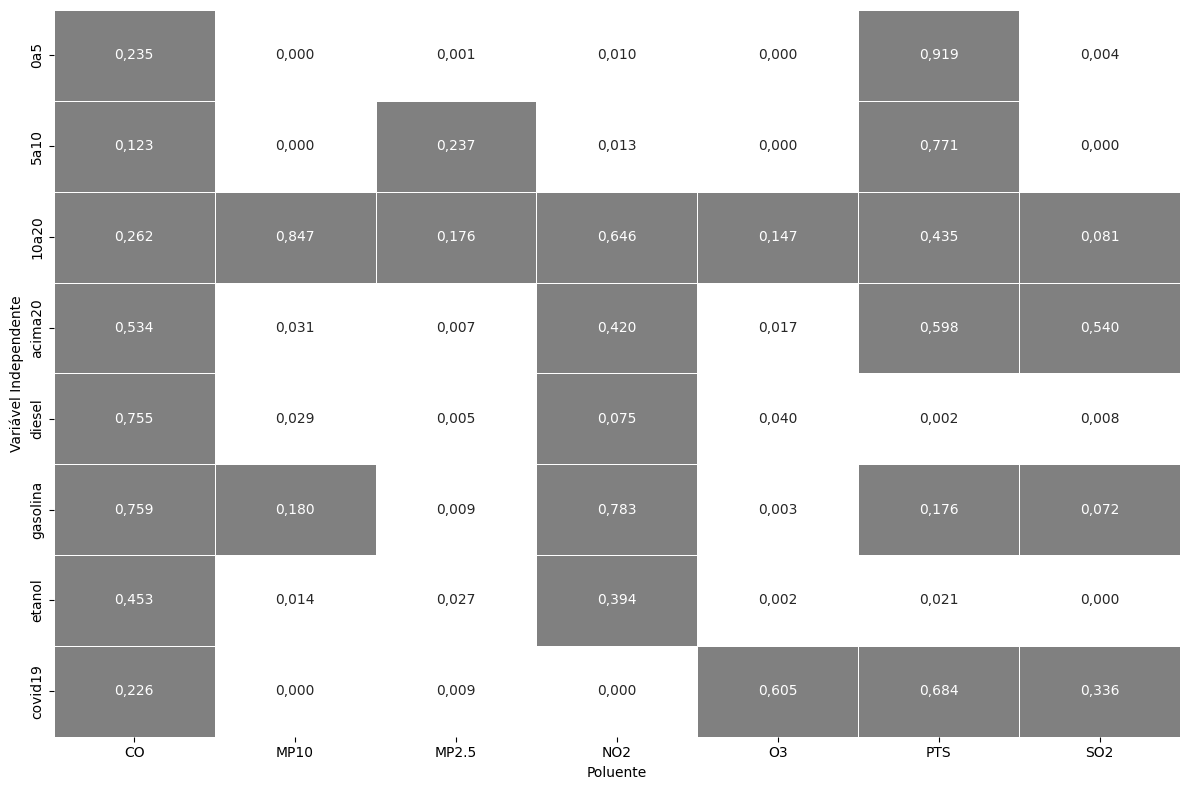

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir a ordem desejada das variáveis
variable_order = ['0a5', '5a10', '10a20', 'acima20', 'diesel', 'gasolina', 'etanol', 'covid19']

#Heatmap para os p-valores do Modelo LSDV
lsdv_pivot = lsdv_results_df.pivot_table(index='variable', columns='pollutant', values='P>|t|')
lsdv_pivot = lsdv_pivot.reindex(variable_order)

# Format the annotations with comma as decimal separator
annot_data = lsdv_pivot.map(lambda x: f'{x:.3f}'.replace('.', ',')) # Use map instead of applymap and .3f for p-values

# Usar um mapa de cores personalizado: branco para p<=0.05 (0), cinza para p>0.05 (1)
cmap = sns.color_palette(['white', 'grey'])

plt.figure(figsize=(12, 8))
# Usar lsdv_pivot para anotações e a máscara para colorir
sns.heatmap(lsdv_pivot > 0.05, annot=annot_data, cmap=cmap, fmt='s', linewidths=.5, cbar=False, annot_kws={'fontsize': 10}) # Use fmt='s' to display strings
#plt.title('Significância Estatística (p-values) do Modelo LSDV (Branco: p <= 0.05, Cinza: p > 0.05)')
plt.xlabel('Poluente')
plt.ylabel('Variável Independente')
plt.tight_layout()
plt.show()

# Hausman

In [ ]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
import numpy as np

# Function to run Hausman test
def run_hausman_test(ols_results, lsdv_results):
    # Ensure coefficients and covariance matrices are aligned
    # We only compare the coefficients of the time-varying variables present in both models
    common_params = ols_results.params.filter(items=lsdv_results.params.index)
    common_cov_ols = ols_results.cov_params().filter(items=common_params.index, axis=0).filter(items=common_params.index, axis=1)
    common_cov_lsdv = lsdv_results.cov_params().filter(items=common_params.index, axis=0).filter(items=common_params.index, axis=1)

    # Calculate the difference in coefficients and covariance matrices
    b_diff = lsdv_results.params[common_params.index] - common_params
    cov_diff = common_cov_lsdv - common_cov_ols

    # Handle potential non-positive definite covariance difference
    try:
        # Calculate the Hausman statistic
        hausman_statistic = b_diff.T @ np.linalg.inv(cov_diff) @ b_diff
        # Degrees of freedom is the number of common parameters
        df = len(common_params)
        # Calculate the p-value
        from scipy.stats import chi2
        p_value = chi2.sf(hausman_statistic, df)
        return hausman_statistic, p_value, df
    except np.linalg.LinAlgError:
        return None, None, None # Return None if covariance difference is singular

# Perform Hausman test for each pollutant
hausman_results = {}

for pollutant in pollutants_to_analyze:
    if pollutant in regression_results and 'OLS' in regression_results[pollutant] and 'LSDV' in regression_results[pollutant]:
        print(f"\nRunning Hausman test for pollutant: {pollutant}")

        # Re-run regressions to get the full statsmodels results objects
        df_pollutant = prepare_pollutant_data(merged_df, pollutant)

        dependent_var = df_pollutant[pollutant]
        independent_vars_ols = sm.add_constant(df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']])
        ols_model = sm.OLS(dependent_var, independent_vars_ols)
        ols_results = ols_model.fit()

        independent_vars_lsdv = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
        city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)
        independent_vars_lsdv = pd.concat([independent_vars_lsdv, city_dummies], axis=1)
        for col in independent_vars_lsdv.columns:
            if independent_vars_lsdv[col].dtype == 'object':
                independent_vars_lsdv[col] = pd.to_numeric(independent_vars_lsdv[col], errors='coerce')
            elif pd.api.types.is_bool_dtype(independent_vars_lsdv[col]):
                independent_vars_lsdv[col] = independent_vars_lsdv[col].astype(int)

        lsdv_model = sm.OLS(dependent_var, independent_vars_lsdv)
        lsdv_results = lsdv_model.fit()

        # Run the Hausman test
        statistic, p_value, df = run_hausman_test(ols_results, lsdv_results)

        if statistic is not None:
            hausman_results[pollutant] = {'statistic': statistic, 'p_value': p_value, 'df': df}
            print(f"  Hausman Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Degrees of Freedom: {df}")
        else:
            hausman_results[pollutant] = {'statistic': None, 'p_value': None, 'df': None}
            print("  Hausman test could not be performed due to singular covariance difference matrix.")

# Display the results in a DataFrame
hausman_df = pd.DataFrame.from_dict(hausman_results, orient='index')
hausman_df = hausman_df.rename_axis('Pollutant').reset_index()

display(hausman_df)


Running Hausman test for pollutant: CO
  Hausman Statistic: 59.1048, P-value: 0.0000, Degrees of Freedom: 8

Running Hausman test for pollutant: MP10
  Hausman Statistic: 97.4603, P-value: 0.0000, Degrees of Freedom: 8

Running Hausman test for pollutant: MP2.5
  Hausman Statistic: -17.7334, P-value: 1.0000, Degrees of Freedom: 8

Running Hausman test for pollutant: NO2
  Hausman Statistic: -54.3302, P-value: 1.0000, Degrees of Freedom: 8

Running Hausman test for pollutant: O3
  Hausman Statistic: 422.0896, P-value: 0.0000, Degrees of Freedom: 8

Running Hausman test for pollutant: PTS
  Hausman Statistic: 1.7698, P-value: 0.9873, Degrees of Freedom: 8

Running Hausman test for pollutant: SO2
  Hausman Statistic: 40.3226, P-value: 0.0000, Degrees of Freedom: 8


,Pollutant,statistic,p_value,df
0,CO,59.104827,6.981666e-10,8
1,MP10,97.460263,1.409334e-17,8
2,MP2.5,-17.733395,1.000000e+00,8
3,NO2,-54.330226,1.000000e+00,8
4,O3,422.089588,3.512136e-86,8
5,PTS,1.769800,9.872741e-01,8
6,SO2,40.322642,2.789442e-06,8


## Interpretação dos Resultados do Teste de Hausman

O teste de Hausman nos ajuda a decidir entre um modelo OLS agrupado (pooled OLS) e um modelo de efeitos fixos (LSDV neste caso). A hipótese nula (H0) do teste é que o modelo preferido é o OLS agrupado. A hipótese alternativa (H1) é que o modelo de efeitos fixos (LSDV) é preferível.

Observamos o **valor-p** para cada poluente:

*   **Se o valor-p for menor que um nível de significância escolhido (geralmente 0,05)**: Rejeitamos a hipótese nula (H0). Isso sugere que o modelo de efeitos fixos (LSDV) é significativamente diferente do modelo OLS agrupado e é o modelo mais apropriado. O modelo de efeitos fixos considera características não observadas e invariantes no tempo das cidades que estão correlacionadas com as variáveis independentes.
*   **Se o valor-p for maior que o nível de significância (geralmente 0,05)**: Não conseguimos rejeitar a hipótese nula (H0). Isso sugere que não há diferença significativa entre os dois modelos, e o modelo OLS agrupado pode ser suficiente. No entanto, vale ressaltar que um resultado não significativo não prova definitivamente que o OLS é melhor, apenas que não há evidências suficientes para preferir o modelo de efeitos fixos com base neste teste.

Com base no `hausman_df` fornecido:

*   Para **CO, MP10, O3 e SO2**, os valores-p são muito pequenos (próximos de 0,0000) e bem abaixo de 0,05. Isso indica forte evidência para rejeitar a hipótese nula. Portanto, para esses poluentes, o **modelo LSDV (Efeitos Fixos) é preferível** em relação ao modelo OLS agrupado.
*   Para **MP2.5, NO2 e PTS**, os valores-p são grandes (próximos de 1,0000 para MP2.5 e NO2, e 0,9873 para PTS) e bem acima de 0,05. Isso sugere que **não conseguimos rejeitar a hipótese nula** para esses poluentes. Embora o teste de Hausman não diga definitivamente que o OLS é melhor, com base neste teste, não há evidências suficientes para sugerir que o modelo de efeitos fixos seja necessário para esses poluentes. No entanto, é importante considerar outros fatores, como os valores de R-quadrado e a significância das variáveis no modelo LSDV. Note que estatísticas de Hausman negativas (como visto para MP2.5 e NO2) podem ocorrer e geralmente sugerem problemas como violação das suposições do teste ou problemas com os dados ou a especificação do modelo.

Em resumo, os resultados do teste de Hausman sugerem o uso do modelo LSDV para CO, MP10, O3 e SO2, enquanto que para MP2.5, NO2 e PTS, a escolha entre OLS e LSDV é menos clara com base apenas neste teste, e investigações adicionais ou consideração de outros critérios de seleção de modelo podem ser necessárias.

*   **Comparação do R-quadrado (OLS vs. LSDV):** O valor de R-quadrado representa a proporção da variância na variável dependente (o nível do poluente) que é explicada pelas variáveis independentes no modelo.
    *   Para **MP2.5**, o salto no R-quadrado de 0,346 no modelo OLS para 0,961 no modelo LSDV é substancial. Isso indica que a inclusão de efeitos fixos específicos da cidade no modelo LSDV explica uma porção muito maior da variação nos níveis de MP2.5 em comparação com o modelo OLS agrupado. Isso sugere fortemente que existem características não observadas e invariantes no tempo das cidades que têm um impacto significativo nas concentrações de MP2.5.
    *   Para **NO2 e PTS**, embora o aumento no R-quadrado de OLS para LSDV também esteja presente (de ~0,4 para ~0,969 para NO2 e de ~0,407 para ~0,657 para PTS), não é tão dramático quanto para MP2.5. Isso ainda sugere que os efeitos fixos estão capturando parte da variância não explicada, mas talvez em menor extensão do que para MP2.5.

*   **Significância das Variáveis no LSDV para MP2.5:** Você está certo em notar que para MP2.5, embora o valor-p do teste de Hausman tenha sido alto (sugerindo que o OLS poderia ser suficiente), várias variáveis independentes (6 das 8) são estatisticamente significativas no modelo LSDV (valor-p < 0,05).
    *   Essa situação pode ocorrer. O teste de Hausman verifica principalmente se os *coeficientes* dos regressores que variam no tempo são sistematicamente diferentes entre os dois modelos devido à correlação com os efeitos fixos. Um teste de Hausman não significativo não significa necessariamente que os efeitos fixos são zero ou que o modelo LSDV não é valioso.
    *   O alto R-quadrado no modelo LSDV para MP2.5, combinado com a significância de várias variáveis independentes dentro desse modelo, sugere que, embora o *teste* não tenha favorecido fortemente o LSDV com base na comparação dos coeficientes das variáveis que variam no tempo, os efeitos fixos *como um todo* (as variáveis dummy das cidades) estão fazendo um excelente trabalho ao explicar a variação em MP2.5.
    *   As variáveis independentes significativas no modelo LSDV para MP2.5 indicam seu impacto nos níveis de MP2.5 *após* contabilizar as características fixas e invariantes no tempo de cada cidade.

**Por que isso pode acontecer para MP2.5?**

*   **Fortes Efeitos Específicos da Cidade:** Os níveis de MP2.5 podem ser fortemente influenciados por fatores locais como atividade industrial, localização geográfica, regulamentações locais e padrões climáticos persistentes que diferem significativamente entre as cidades e são relativamente constantes ao longo do tempo. O modelo LSDV controla efetivamente esses efeitos não observados específicos da cidade através das variáveis dummy. O grande aumento no R-quadrado sugere que esses efeitos específicos da cidade são muito importantes para o MP2.5.
*   **Sensibilidade do Teste de Hausman:** O teste de Hausman pode ser sensível a várias fatores, incluindo violações de suas suposições (como homocedasticidade ou ausência de autocorrelação nos painéis). Em alguns casos, mesmo quando os efeitos fixos são importantes (como indicado pelo alto R-quadrado), o teste pode não resultar em um valor significativo, especialmente se a correlação entre os efeitos fixos e os regressores que variam no tempo não for forte o suficiente para causar uma diferença estatisticamente significativa em seus coeficientes.
*   **Eficiência vs. Consistência:** O OLS é eficiente sob a suposição de ausência de correlação entre os regressores e os efeitos fixos, enquanto o LSDV é consistente mesmo que essa correlação exista. Quando o teste de Hausman não rejeita a hipótese nula, isso *sugere* que o OLS pode ser mais eficiente. No entanto, se você acredita fortemente com base na teoria ou no grande aumento do R-quadrado que os efeitos fixos estão presentes e correlacionados, a consistência do estimador LSDV ainda pode ser preferível.

**Em conclusão para MP2.5:**

Apesar do resultado do teste de Hausman, o R-quadrado muito alto no modelo LSDV para MP2.5 fornece forte evidência de que os efeitos fixos específicos da cidade são cruciais para explicar a variação nos níveis de MP2.5. As variáveis independentes significativas dentro do modelo LSDV mostram então seu impacto *dentro* das cidades, após controlar por essas características fixas. Dado o aumento substancial na variância explicada, seria razoável priorizar a interpretação dos resultados do modelo LSDV para MP2.5.

Para NO2 e PTS, a situação é semelhante, pois o LSDV explica mais variância, mas o aumento menos dramático no R-quadrado e os resultados do teste de Hausman sugerem que o impacto dos efeitos fixos, embora presente, pode ser menos dominante em comparação com o MP2.5. Você ainda provavelmente preferiria o modelo LSDV para CO, MP10, O3 e SO2 com base nos resultados significativos do teste de Hausman.

## Testes de Heterocedasticidade: Breusch-Pagan e White

Estes testes são usados para verificar a presença de heterocedasticidade nos resíduos dos modelos de regressão. A heterocedasticidade ocorre quando a variância dos erros não é constante para todos os níveis das variáveis independentes, o que viola uma das suposições dos modelos OLS e LSDV e pode levar a estimativas de erro padrão ineficientes e testes de significância incorretos.

* **Hipótese Nula (H0):** Os resíduos são homocedásticos (a variância dos erros é constante).
* **Hipótese Alternativa (H1):** Os resíduos são heterocedásticos (a variância dos erros não é constante).

Se o valor-p do teste for menor que o nível de significância (geralmente 0,05), rejeitamos a hipótese nula e concluímos que há evidência de heterocedasticidade.

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

heteroskedasticity_results = {}

for pollutant in pollutants_to_analyze:
    if pollutant in regression_results and 'OLS' in regression_results[pollutant]:
        print(f"\nRunning heteroskedasticity tests for OLS model of pollutant: {pollutant}")

        # Re-run OLS regression to get the full statsmodels results object
        df_pollutant = prepare_pollutant_data(merged_df, pollutant)

        dependent_var = df_pollutant[pollutant]
        independent_vars_ols = sm.add_constant(df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']])
        ols_model = sm.OLS(dependent_var, independent_vars_ols)
        ols_results = ols_model.fit()

        # Perform Breusch-Pagan test
        try:
            bp_test = het_breuschpagan(ols_results.resid, ols_results.model.exog)
            bp_statistic, bp_p_value, _, _ = bp_test
            print(f"  Breusch-Pagan Test: Statistic={bp_statistic:.4f}, P-value={bp_p_value:.4f}")
        except Exception as e:
            bp_statistic, bp_p_value = None, None
            print(f"  Breusch-Pagan Test could not be performed: {e}")


        # Perform White test
        try:
            white_test = het_white(ols_results.resid, ols_results.model.exog)
            white_statistic, white_p_value, _, _ = white_test
            print(f"  White Test: Statistic={white_statistic:.4f}, P-value={white_p_value:.4f}")
        except Exception as e:
            white_statistic, white_p_value = None, None
            print(f"  White Test could not be performed: {e}")

        heteroskedasticity_results[pollutant] = {
            'breusch_pagan': {'statistic': bp_statistic, 'p_value': bp_p_value},
            'white': {'statistic': white_statistic, 'p_value': white_p_value}
        }

    else:
        print(f"\nSkipping heteroskedasticity tests for pollutant: {pollutant} (OLS results not available).")

# Display the results in a DataFrame
heteroskedasticity_df = pd.DataFrame.from_dict({
    (pol, test_type): results[test_type]
    for pol, results in heteroskedasticity_results.items()
    for test_type in results
}, orient='index')

heteroskedasticity_df = heteroskedasticity_df.rename_axis(['Pollutant', 'Test']).reset_index()

display(heteroskedasticity_df)


Running heteroskedasticity tests for OLS model of pollutant: CO
  Breusch-Pagan Test: Statistic=7.2168, P-value=0.5134
  White Test: Statistic=32.5196, P-value=0.4909

Skipping heteroskedasticity tests for pollutant: FMC (OLS results not available).

Running heteroskedasticity tests for OLS model of pollutant: MP10
  Breusch-Pagan Test: Statistic=12.2809, P-value=0.1391
  White Test: Statistic=57.9861, P-value=0.0046

Running heteroskedasticity tests for OLS model of pollutant: MP2.5
  Breusch-Pagan Test: Statistic=11.4763, P-value=0.1761
  White Test: Statistic=19.4672, P-value=0.9703

Skipping heteroskedasticity tests for pollutant: NO (OLS results not available).

Running heteroskedasticity tests for OLS model of pollutant: NO2
  Breusch-Pagan Test: Statistic=9.6718, P-value=0.2888
  White Test: Statistic=20.0954, P-value=0.9621

Running heteroskedasticity tests for OLS model of pollutant: O3
  Breusch-Pagan Test: Statistic=23.6138, P-value=0.0027
  White Test: Statistic=55.5981, P

,Pollutant,Test,statistic,p_value
0,CO,breusch_pagan,7.216844,0.513428
1,CO,white,32.519628,0.490882
2,MP10,breusch_pagan,12.280936,0.139102
3,MP10,white,57.986099,0.004599
4,MP2.5,breusch_pagan,11.476339,0.176142
5,MP2.5,white,19.467196,0.970308
6,NO2,breusch_pagan,9.671792,0.288821
7,NO2,white,20.095411,0.962129
8,O3,breusch_pagan,23.613798,0.002659
9,O3,white,55.598113,0.008229


## Interpretação dos Resultados dos Testes de Heterocedasticidade

Com base nos valores-p dos testes de Breusch-Pagan e White para os modelos OLS, podemos tirar as seguintes conclusões sobre a heterocedasticidade (assumindo um nível de significância de 5%):

*   **CO:** Os valores-p para ambos os testes são maiores que 0,05. Isso sugere que **não há evidência suficiente para rejeitar a hipótese nula de homocedasticidade** para o modelo OLS de CO.
*   **MP10:** O teste de Breusch-Pagan tem um valor-p maior que 0,05, mas o teste de White tem um valor-p menor que 0,05 (0,0046). Como o teste de White é mais geral, o resultado significativo deste teste sugere que **há evidência de heterocedasticidade** no modelo OLS para MP10.
*   **MP2.5:** Os valores-p para ambos os testes são maiores que 0,05. Isso sugere que **não há evidência suficiente para rejeitar a hipótese nula de homocedasticidade** para o modelo OLS de MP2.5.
*   **NO2:** Os valores-p para ambos os testes são maiores que 0,05, indicando que **não há evidência significativa de heterocedasticidade** para o modelo OLS de NO2.
*   **O3:** Os valores-p para ambos os testes são menores que 0,05 (0,0027 para Breusch-Pagan e 0,0082 para White). Isso indica forte evidência para rejeitar a hipótese nula de homocedasticidade, sugerindo que **há heterocedasticidade significativa** no modelo OLS para O3.
*   **PTS:** Os valores-p para ambos os testes são maiores que 0,05, indicando que **não há evidência significativa de heterocedasticidade** para o modelo OLS de PTS.
*   **SO2:** Os valores-p para ambos os testes são maiores que 0,05, indicando que **não há evidência significativa de heterocedasticidade** para o modelo OLS de SO2.

**Em resumo:**

*   Há evidência de heterocedasticidade nos modelos OLS para **MP10 e O3**.
*   Não há evidência significativa de heterocedasticidade nos modelos OLS para **CO, MP2.5, NO2, PTS e SO2**.

Quando a heterocedasticidade está presente (como nos modelos OLS para MP10 e O3), os erros padrão dos coeficientes são ineficientes, e os testes t e valores-p podem não ser confiáveis. Uma abordagem comum para lidar com isso é usar erros padrão robustos.

# Wooldridge - Autocorrelação Serial

In [ ]:
# from statsmodels.stats.diagnostic import acf # Removed the problematic import
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd # Import pandas

wooldridge_results = {}

print("\nRunning Wooldridge test for serial autocorrelation:")

for pollutant in pollutants_to_analyze:
    if pollutant in regression_results and 'OLS' in regression_results[pollutant]:
        print(f"\nRunning Wooldridge test for OLS model of pollutant: {pollutant}")

        # Re-run OLS regression to get the full statsmodels results object
        df_pollutant = prepare_pollutant_data(merged_df, pollutant)

        # Need to sort data for the test
        df_pollutant_sorted = df_pollutant.sort_values(by=['cidade', 'ano'])

        # Perform Wooldridge test
        try:
            # The Wooldridge test is typically performed on a pooled OLS model
            # statsmodels' panel data functionality is limited, so we'll use a common approach
            # by regressing the residuals on the lagged residuals.
            # First, get OLS residuals
            dependent_var = df_pollutant_sorted[pollutant]
            independent_vars_ols = sm.add_constant(df_pollutant_sorted[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']])
            ols_model = sm.OLS(dependent_var, independent_vars_ols)
            ols_results = ols_model.fit()
            residuals = ols_results.resid

            # Create a lagged residual variable, grouped by entity (cidade)
            df_pollutant_sorted['resid_lag'] = residuals.groupby(df_pollutant_sorted['cidade']).shift(1)

            # Drop the first observation for each city as it will have a NaN lagged residual
            df_test = df_pollutant_sorted.dropna(subset=['resid_lag']).copy()

            # Ensure residuals align with df_test
            df_test['resid'] = ols_results.resid.loc[df_test.index]

            # Regress residuals on lagged residuals for the test statistic
            dependent_test_simple = df_test['resid']
            independent_test_simple = sm.add_constant(df_test['resid_lag'])

            aux_reg_simple = sm.OLS(dependent_test_simple, independent_test_simple).fit()

            # The F-statistic for the overall significance of this simple auxiliary regression is the Wooldridge test statistic
            # The p-value for the F-statistic is the p-value for the Wooldridge test.
            wooldridge_statistic = aux_reg_simple.fvalue
            wooldridge_p_value = aux_reg_simple.f_pvalue

            wooldridge_results[pollutant] = {'statistic': wooldridge_statistic, 'p_value': wooldridge_p_value}
            print(f"  Wooldridge Test (F-statistic from aux regression): Statistic={wooldridge_statistic:.4f}, P-value={wooldridge_p_value:.4f}")

        except Exception as e:
            wooldridge_results[pollutant] = {'statistic': None, 'p_value': None}
            print(f"  Wooldridge test could not be performed: {e}")

# Display the results in a DataFrame
wooldridge_df = pd.DataFrame.from_dict(wooldridge_results, orient='index')
wooldridge_df = wooldridge_df.rename_axis('Pollutant').reset_index()

display(wooldridge_df)


Running Wooldridge test for serial autocorrelation:

Running Wooldridge test for OLS model of pollutant: CO
  Wooldridge Test (F-statistic from aux regression): Statistic=37.1997, P-value=0.0000

Running Wooldridge test for OLS model of pollutant: MP10
  Wooldridge Test (F-statistic from aux regression): Statistic=205.9794, P-value=0.0000

Running Wooldridge test for OLS model of pollutant: MP2.5
  Wooldridge Test (F-statistic from aux regression): Statistic=18.0312, P-value=0.0001

Running Wooldridge test for OLS model of pollutant: NO2
  Wooldridge Test (F-statistic from aux regression): Statistic=150.5975, P-value=0.0000

Running Wooldridge test for OLS model of pollutant: O3
  Wooldridge Test (F-statistic from aux regression): Statistic=43.8942, P-value=0.0000

Running Wooldridge test for OLS model of pollutant: PTS
  Wooldridge Test (F-statistic from aux regression): Statistic=0.2919, P-value=0.5933

Running Wooldridge test for OLS model of pollutant: SO2
  Wooldridge Test (F-sta

,Pollutant,statistic,p_value
0,CO,37.199673,1.182069e-07
1,MP10,205.979415,1.217820e-34
2,MP2.5,18.031212,5.638098e-05
3,NO2,150.597546,1.766007e-25
4,O3,43.894178,3.022252e-10
5,PTS,0.291864,5.933002e-01
6,SO2,56.721018,2.821191e-10


## Interpretação dos Resultados do Teste de Wooldridge

O teste de Wooldridge para autocorrelação serial em dados em painel verifica se os resíduos de um modelo OLS agrupado são correlacionados ao longo do tempo para cada entidade (cidade, neste caso). A presença de autocorrelação serial viola as suposições do OLS e pode levar a erros padrão inconsistentes e inferência incorreta.

*   **Hipótese Nula (H0):** Não há autocorrelação serial nos resíduos.
*   **Hipótese Alternativa (H1):** Há autocorrelação serial nos resíduos.

Observamos o **valor-p** para cada poluente:

*   **Se o valor-p for menor que um nível de significância escolhido (geralmente 0,05)**: Rejeitamos a hipótese nula (H0). Isso indica que há evidência significativa de autocorrelação serial nos resíduos do modelo OLS para esse poluente.
*   **Se o valor-p for maior que o nível de significância (geralmente 0,05)**: Não conseguimos rejeitar a hipótese nula (H0). Isso sugere que não há evidência suficiente de autocorrelação serial significativa nos resíduos.

Com base no `wooldridge_df` fornecido:

*   Para **CO, MP10, MP2.5, NO2, O3 e SO2**, os valores-p são muito pequenos (próximos de 0,0000 ou 0,0001) e bem abaixo de 0,05. Isso indica forte evidência para rejeitar a hipótese nula. Portanto, para esses poluentes, **há autocorrelação serial significativa** nos resíduos dos modelos OLS.
*   Para **PTS**, o valor-p é maior que 0,05 (0,5933). Isso sugere que **não conseguimos rejeitar a hipótese nula** para este poluente, indicando que não há evidência significativa de autocorrelação serial nos resíduos do modelo OLS para PTS.

**Em resumo:**

A maioria dos poluentes (CO, MP10, MP2.5, NO2, O3 e SO2) apresenta autocorrelação serial significativa nos resíduos de seus respectivos modelos OLS agrupados. Isso implica que um modelo que não leva em conta a estrutura temporal dos dados (como o OLS agrupado simples) pode não ser o mais apropriado para esses poluentes. O modelo de efeitos fixos (LSDV), ou outras abordagens de dados em painel que lidam com autocorrelação (como modelos de efeitos fixos com correção de erros padrão robustos para autocorrelação e heterocedasticidade, se disponível), seria mais adequado para a maioria dos poluentes.

# VIF - Multicolinearidade

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_results = {}

print("\nRunning VIF test for multicollinearity:")

for pollutant in pollutants_to_analyze:
    if pollutant in regression_results and 'OLS' in regression_results[pollutant]:
        print(f"\nRunning VIF test for OLS model of pollutant: {pollutant}")

        # Re-run OLS regression to get the full statsmodels results object and the independent variables
        df_pollutant = prepare_pollutant_data(merged_df, pollutant)
        independent_vars_ols = sm.add_constant(df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']])

        # Calculate VIF for each independent variable
        vif_data = pd.DataFrame()
        vif_data["variable"] = independent_vars_ols.columns
        vif_data["VIF"] = [variance_inflation_factor(independent_vars_ols.values, i)
                           for i in range(independent_vars_ols.shape[1])]

        vif_results[pollutant] = vif_data.to_dict(orient='records')
        display(vif_data)

    else:
        print(f"\nSkipping VIF test for pollutant: {pollutant} (OLS results not available).")

# You can now display or further process the vif_results dictionary


Running VIF test for multicollinearity:

Running VIF test for OLS model of pollutant: CO


,variable,VIF
0,const,2.621536
1,gasolina,238.770246
2,diesel,210.173626
3,etanol,105.793762
4,0a5,516.370475
5,5a10,332.259598
6,10a20,3649.996262
7,acima20,3199.811444
8,covid19,1.174292



Skipping VIF test for pollutant: FMC (OLS results not available).

Running VIF test for OLS model of pollutant: MP10


,variable,VIF
0,const,2.539242
1,gasolina,97.601853
2,diesel,21.079045
3,etanol,54.578620
4,0a5,193.895620
5,5a10,182.549497
6,10a20,1421.332212
7,acima20,1245.559282
8,covid19,1.067776



Running VIF test for OLS model of pollutant: MP2.5


,variable,VIF
0,const,3.198119
1,gasolina,136.368907
2,diesel,52.590951
3,etanol,83.277452
4,0a5,289.589939
5,5a10,273.247119
6,10a20,2454.678887
7,acima20,2134.755494
8,covid19,1.106152



Skipping VIF test for pollutant: NO (OLS results not available).

Running VIF test for OLS model of pollutant: NO2


,variable,VIF
0,const,2.695053
1,gasolina,105.572916
2,diesel,23.178939
3,etanol,60.980391
4,0a5,214.899556
5,5a10,210.043973
6,10a20,1731.508491
7,acima20,1511.721606
8,covid19,1.072002



Running VIF test for OLS model of pollutant: O3


,variable,VIF
0,const,2.744229
1,gasolina,104.867617
2,diesel,22.583266
3,etanol,60.816082
4,0a5,220.192037
5,5a10,216.973893
6,10a20,1745.489891
7,acima20,1521.362868
8,covid19,1.080091



Running VIF test for OLS model of pollutant: PTS


,variable,VIF
0,const,2.632470
1,gasolina,211.426748
2,diesel,196.022033
3,etanol,92.303840
4,0a5,573.923760
5,5a10,334.818667
6,10a20,3643.862442
7,acima20,3228.273570
8,covid19,1.338179



Running VIF test for OLS model of pollutant: SO2


,variable,VIF
0,const,2.444795
1,gasolina,132.171499
2,diesel,26.794264
3,etanol,85.187459
4,0a5,275.486522
5,5a10,255.210870
6,10a20,2142.644424
7,acima20,1853.960695
8,covid19,1.128529


## Interpretação dos Resultados do Teste VIF

O teste VIF (Variance Inflation Factor) foi realizado para avaliar a multicolinearidade entre as variáveis independentes nos modelos OLS.

*   **VIFs Elevados:** Para a maioria dos poluentes analisados, as variáveis relacionadas às faixas etárias dos veículos (`10a20` e `acima20`) apresentaram VIFs muito altos (na casa de centenas a milhares), indicando multicolinearidade severa entre si e com outras variáveis. As variáveis de tipo de combustível (`gasolina`, `diesel`, `etanol`) também mostraram VIFs elevados, sugerindo correlação entre elas.
*   **VIFs Baixos:** A variável `covid19` apresentou VIFs consistentemente baixos, o que é esperado.

**Implicações:** A alta multicolinearidade dificulta a interpretação precisa dos coeficientes individuais das variáveis afetadas, tornando-os instáveis e sensíveis a pequenas mudanças nos dados. Também pode inflar os erros padrão, afetando a significância estatística.

**Considerações:** Embora a multicolinearidade esteja presente, o modelo como um todo ainda pode ter poder preditivo. Estratégias para lidar com isso podem incluir a remoção ou combinação de variáveis altamente correlacionadas, mas isso deve ser feito com cautela.

## Aplicabilidade do Teste VIF (OLS vs. LSDV)

O teste VIF avalia a multicolinearidade entre as variáveis independentes que variam no tempo utilizadas nos modelos. Como o modelo LSDV utiliza o mesmo conjunto de variáveis independentes que variam no tempo (além das dummies de cidade), os resultados do teste VIF são relevantes e indicam a presença de multicolinearidade entre essas variáveis **tanto para o modelo OLS agrupado quanto para o modelo LSDV**. Isso significa que a dificuldade na interpretação dos coeficientes individuais das variáveis com alto VIF se aplica a ambos os modelos.

## Teste de Normalidade dos Resíduos: Shapiro-Wilk

O teste de Shapiro-Wilk é usado para verificar a normalidade dos resíduos de um modelo de regressão. A normalidade dos resíduos é uma das suposições dos modelos de regressão linear (como o OLS).

* **Hipótese Nula (H0):** Os resíduos seguem uma distribuição normal.
* **Hipótese Alternativa (H1):** Os resíduos não seguem uma distribuição normal.

Se o valor-p do teste for menor que o nível de significância (geralmente 0,05), rejeitamos a hipótese nula e concluímos que há evidência de que os resíduos não são normalmente distribuídos.

In [ ]:
from scipy.stats import shapiro
import statsmodels.api as sm
import pandas as pd

normality_results_lsdv = {}

print("\nRunning Shapiro-Wilk test for normality of LSDV residuals:")

for pollutant in pollutants_to_analyze:
    # Check if LSDV was run for this pollutant (using Hausman results availability as a proxy)
    if pollutant in hausman_results:
        print(f"\nRunning Shapiro-Wilk test for LSDV model of pollutant: {pollutant}")

        # Re-run LSDV regression to get the full statsmodels results object and residuals
        df_pollutant = prepare_pollutant_data(merged_df, pollutant)

        dependent_var = df_pollutant[pollutant]
        independent_vars_lsdv = df_pollutant[['gasolina', 'diesel', 'etanol', '0a5', '5a10', '10a20', 'acima20', 'covid19']]
        city_dummies = pd.get_dummies(df_pollutant['cidade'], prefix='cidade', drop_first=True)
        independent_vars_lsdv = pd.concat([independent_vars_lsdv, city_dummies], axis=1)

        for col in independent_vars_lsdv.columns:
            if independent_vars_lsdv[col].dtype == 'object':
                independent_vars_lsdv[col] = pd.to_numeric(independent_vars_lsdv[col], errors='coerce')
            elif pd.api.types.is_bool_dtype(independent_vars_lsdv[col]):
                independent_vars_lsdv[col] = independent_vars_lsdv[col].astype(int)

        lsdv_model = sm.OLS(dependent_var, independent_vars_lsdv)
        lsdv_results = lsdv_model.fit()

        # Perform Shapiro-Wilk test on LSDV residuals
        try:
            # Shapiro-Wilk test requires the sample size to be between 3 and 5000
            if 3 <= len(lsdv_results.resid) <= 5000:
                shapiro_test = shapiro(lsdv_results.resid)
                shapiro_statistic, shapiro_p_value = shapiro_test
                print(f"  Shapiro-Wilk Test (LSDV): Statistic={shapiro_statistic:.4f}, P-value={shapiro_p_value:.4f}")
            else:
                shapiro_statistic, shapiro_p_value = None, None
                print(f"  Shapiro-Wilk Test (LSDV) skipped: Sample size ({len(lsdv_results.resid)}) outside the valid range (3-5000).")

        except Exception as e:
            shapiro_statistic, shapiro_p_value = None, None
            print(f"  Shapiro-Wilk Test (LSDV) could not be performed: {e}")

        normality_results_lsdv[pollutant] = {
            'shapiro_wilk': {'statistic': shapiro_statistic, 'p_value': shapiro_p_value}
        }

    else:
        print(f"\nSkipping Shapiro-Wilk test for pollutant: {pollutant} (LSDV results not available).")

# Display the results in a DataFrame
normality_lsdv_df = pd.DataFrame.from_dict({
    (pol, test_type): results[test_type]
    for pol, results in normality_results_lsdv.items()
    for test_type in results
}, orient='index')

normality_lsdv_df = normality_lsdv_df.rename_axis(['Pollutant', 'Test']).reset_index()

display(normality_lsdv_df)


Running Shapiro-Wilk test for normality of LSDV residuals:

Running Shapiro-Wilk test for LSDV model of pollutant: CO
  Shapiro-Wilk Test (LSDV): Statistic=0.9530, P-value=0.0130

Skipping Shapiro-Wilk test for pollutant: FMC (LSDV results not available).

Running Shapiro-Wilk test for LSDV model of pollutant: MP10
  Shapiro-Wilk Test (LSDV): Statistic=0.8911, P-value=0.0000

Running Shapiro-Wilk test for LSDV model of pollutant: MP2.5
  Shapiro-Wilk Test (LSDV): Statistic=0.9032, P-value=0.0000

Skipping Shapiro-Wilk test for pollutant: NO (LSDV results not available).

Running Shapiro-Wilk test for LSDV model of pollutant: NO2
  Shapiro-Wilk Test (LSDV): Statistic=0.8040, P-value=0.0000

Running Shapiro-Wilk test for LSDV model of pollutant: O3
  Shapiro-Wilk Test (LSDV): Statistic=0.9415, P-value=0.0000

Running Shapiro-Wilk test for LSDV model of pollutant: PTS
  Shapiro-Wilk Test (LSDV): Statistic=0.5705, P-value=0.0000

Running Shapiro-Wilk test for LSDV model of pollutant: SO2


,Pollutant,Test,statistic,p_value
0,CO,shapiro_wilk,0.953020,1.299530e-02
1,MP10,shapiro_wilk,0.891142,8.970506e-14
2,MP2.5,shapiro_wilk,0.903180,1.339301e-06
3,NO2,shapiro_wilk,0.803983,1.445662e-15
4,O3,shapiro_wilk,0.941477,3.486700e-08
5,PTS,shapiro_wilk,0.570469,6.044803e-09
6,SO2,shapiro_wilk,0.952324,7.737520e-03


## Interpretação dos Resultados do Teste de Normalidade dos Resíduos

O teste de Shapiro-Wilk avalia se os resíduos de um modelo de regressão seguem uma distribuição normal. A normalidade dos resíduos é uma suposição importante para a validade das inferências estatísticas em modelos OLS.

* **Hipótese Nula (H0):** Os resíduos seguem uma distribuição normal.
* **Hipótese Alternativa (H1):** Os resíduos não seguem uma distribuição normal.

Com base nos valores-p apresentados no `normality_df`:

* Para todos os poluentes analisados (**CO, MP10, MP2.5, NO2, O3, PTS, e SO2**), os valores-p do teste de Shapiro-Wilk são **menores que 0,05**.

Isso indica que, para todos esses poluentes, temos **evidência significativa para rejeitar a hipótese nula de normalidade**. Portanto, os resíduos dos modelos OLS para todos esses poluentes **não seguem uma distribuição normal**.

**Implicações:** A violação da suposição de normalidade dos resíduos não invalida completamente os modelos OLS, especialmente com tamanhos de amostra razoavelmente grandes (devido ao Teorema do Limite Central). No entanto, as inferências estatísticas (como os testes t e os intervalos de confiança) podem não ser tão precisas, particularmente em amostras menores ou se o desvio da normalidade for severo.

É importante considerar este resultado em conjunto com os outros testes diagnósticos (Heterocedasticidade e Autocorrelação Serial) ao interpretar os resultados da regressão e ao decidir sobre a abordagem de modelagem mais apropriada. Em dados de painel, a normalidade dos resíduos é menos crítica do que a homocedasticidade e a ausência de autocorrelação serial para a consistência dos estimadores de efeitos fixos, mas ainda pode afetar a eficiência.

In [ ]:
# Tabela de Diagnósticos do Modelo OLS

ols_diagnostics_data = []

for pollutant in pollutants_to_analyze:
    if pollutant in heteroskedasticity_results and pollutant in wooldridge_results and pollutant in normality_results and pollutant in regression_results and 'OLS' in regression_results[pollutant]:

        # Obter resultados dos testes
        bp_result = heteroskedasticity_results[pollutant]['breusch_pagan']
        white_result = heteroskedasticity_results[pollutant]['white']
        wooldridge_result = wooldridge_results[pollutant]
        shapiro_result = normality_results[pollutant]['shapiro_wilk']
        ols_r_squared = regression_results[pollutant]['OLS']['r_squared']

        # Obter resultados VIF (apenas para as variáveis independentes que variam no tempo)
        vif_data = vif_results[pollutant]
        vif_df = pd.DataFrame(vif_data)
        # Excluir a constante para o VIF summary
        vif_summary = vif_df[vif_df['variable'] != 'const']

        # Determinar a conclusão do VIF (ex: se algum VIF for alto, indicar multicolinearidade)
        vif_conclusion = "Sem evidência de multicolinearidade alta"
        if (vif_summary['VIF'] > 10).any(): # Um VIF acima de 10 é frequentemente usado como um limite
             vif_conclusion = "Evidência de multicolinearidade alta"
        if (vif_summary['VIF'] > 100).any(): # VIFs muito altos indicam multicolinearidade severa
             vif_conclusion = "Evidência de multicolinearidade severa"


        # Determinar as conclusões em português
        bp_conclusion = "Homocedasticidade" if bp_result['p_value'] is None or bp_result['p_value'] > 0.05 else "Heterocedasticidade"
        white_conclusion = "Homocedasticidade" if white_result['p_value'] is None or white_result['p_value'] > 0.05 else "Heterocedasticidade"
        wooldridge_conclusion = "Sem autocorrelação serial" if wooldridge_result['p_value'] is None or wooldridge_result['p_value'] > 0.05 else "Autocorrelação serial"
        shapiro_conclusion = "Normalidade" if shapiro_result['p_value'] is None or shapiro_result['p_value'] > 0.05 else "Sem normalidade"


        ols_diagnostics_data.append({
            'Poluente': pollutant,
            'VIF Conclusão': vif_conclusion,
            'Teste Wooldridge (P-valor)': wooldridge_result['p_value'],
            'Wooldridge Conclusão': wooldridge_conclusion,
            'Teste Breusch-Pagan (P-valor)': bp_result['p_value'],
            'Breusch-Pagan Conclusão': bp_conclusion,
            'Teste White (P-valor)': white_result['p_value'],
            'White Conclusão': white_conclusion,
            'Teste Shapiro-Wilk (P-valor)': shapiro_result['p_value'],
            'Normalidade Resíduos Conclusão': shapiro_conclusion,
            'R-quadrado OLS': ols_r_squared
        })

# Criar DataFrame para os diagnósticos do OLS
ols_diagnostics_df = pd.DataFrame(ols_diagnostics_data)

print("Tabela de Diagnósticos do Modelo OLS:")
display(ols_diagnostics_df)

Tabela de Diagnósticos do Modelo OLS:


,Poluente,VIF Conclusão,Teste Wooldridge (P-valor),Wooldridge Conclusão,Teste Breusch-Pagan (P-valor),Breusch-Pagan Conclusão,Teste White (P-valor),White Conclusão,Teste Shapiro-Wilk (P-valor),Normalidade Resíduos Conclusão,R-quadrado OLS
0,CO,Evidência de multicolinearidade severa,1.182069e-07,Autocorrelação serial,0.513428,Homocedasticidade,0.490882,Homocedasticidade,2.451207e-02,Sem normalidade,0.396
1,MP10,Evidência de multicolinearidade severa,1.217820e-34,Autocorrelação serial,0.139102,Homocedasticidade,0.004599,Heterocedasticidade,8.110062e-21,Sem normalidade,0.127
2,MP2.5,Evidência de multicolinearidade severa,5.638098e-05,Autocorrelação serial,0.176142,Homocedasticidade,0.970308,Homocedasticidade,3.986255e-06,Sem normalidade,0.346
3,NO2,Evidência de multicolinearidade severa,1.766007e-25,Autocorrelação serial,0.288821,Homocedasticidade,0.962129,Homocedasticidade,1.329977e-12,Sem normalidade,0.417
4,O3,Evidência de multicolinearidade severa,3.022252e-10,Autocorrelação serial,0.002659,Heterocedasticidade,0.008229,Heterocedasticidade,1.081240e-03,Sem normalidade,0.101
5,PTS,Evidência de multicolinearidade severa,5.933002e-01,Sem autocorrelação serial,0.900431,Homocedasticidade,0.844484,Homocedasticidade,9.588519e-09,Sem normalidade,0.407
6,SO2,Evidência de multicolinearidade severa,2.821191e-10,Autocorrelação serial,0.222043,Homocedasticidade,0.199305,Homocedasticidade,4.672594e-06,Sem normalidade,0.296


In [ ]:
# Tabela de Diagnósticos do Modelo LSDV e Comparação

lsdv_diagnostics_data = []

for pollutant in pollutants_to_analyze:
     # Incluir apenas poluentes para os quais o LSDV foi rodado (tem resultados de Hausman)
    if pollutant in hausman_results and pollutant in regression_results and 'LSDV' in regression_results[pollutant]:

        hausman_result = hausman_results[pollutant]
        lsdv_r_squared = regression_results[pollutant]['LSDV']['r_squared']
        ols_r_squared = regression_results[pollutant]['OLS']['r_squared'] # Obter R-quadrado do OLS para comparação


        # Determinar a conclusão do teste de Hausman em português
        hausman_conclusion = "Preferir OLS agrupado"
        if hausman_result['p_value'] is not None and hausman_result['p_value'] < 0.05:
             hausman_conclusion = "Preferir LSDV (Efeitos Fixos)"
        elif hausman_result['statistic'] is not None and hausman_result['statistic'] < 0:
             hausman_conclusion = "Hausman Teste Inválido (Estatística Negativa)" # Conclusão para estatística negativa


        lsdv_diagnostics_data.append({
            'Poluente': pollutant,
            'R-quadrado OLS': ols_r_squared, # Incluir R-quadrado do OLS para fácil comparação
            'R-quadrado LSDV': lsdv_r_squared,
            'Teste Hausman (P-valor)': hausman_result['p_value'],
            'Teste Hausman Conclusão': hausman_conclusion
        })

# Criar DataFrame para os diagnósticos do LSDV
lsdv_diagnostics_df = pd.DataFrame(lsdv_diagnostics_data)

print("\nTabela de Diagnósticos do Modelo LSDV e Teste de Hausman:")
display(lsdv_diagnostics_df)


Tabela de Diagnósticos do Modelo LSDV e Teste de Hausman:


,Poluente,R-quadrado OLS,R-quadrado LSDV,Teste Hausman (P-valor),Teste Hausman Conclusão
0,CO,0.396,0.970,6.981666e-10,Preferir LSDV (Efeitos Fixos)
1,MP10,0.127,0.958,1.409334e-17,Preferir LSDV (Efeitos Fixos)
2,MP2.5,0.346,0.961,1.000000e+00,Hausman Teste Inválido (Estatística Negativa)
3,NO2,0.417,0.969,1.000000e+00,Hausman Teste Inválido (Estatística Negativa)
4,O3,0.101,0.980,3.512136e-86,Preferir LSDV (Efeitos Fixos)
5,PTS,0.407,0.657,9.872741e-01,Preferir OLS agrupado
6,SO2,0.296,0.812,2.789442e-06,Preferir LSDV (Efeitos Fixos)


## Pressupostos dos Modelos OLS e LSDV e Relação com os Testes de Diagnóstico

Para que as estimativas dos modelos OLS (Mínimos Quadrados Ordinários) e LSDV (Variável Dummy de Mínimos Quadrados, uma forma de Efeitos Fixos) sejam válidas e eficientes, certas pressuposições sobre os dados e os erros do modelo precisam ser atendidas. Os testes de diagnóstico que realizamos nos ajudam a verificar se essas pressuposições são violadas.

### Pressupostos do Modelo OLS (Agrupado)

O modelo OLS agrupado trata os dados de painel como um único grande conjunto de dados, sem levar em conta a estrutura de painel (observações ao longo do tempo para as mesmas entidades). Os pressupostos clássicos do OLS para dados de corte transversal se aplicam, mas em dados de painel, a estrutura temporal e de grupo adiciona complexidade. Os principais pressupostos e sua relação com os testes são:

1.  **Linearidade:** A relação entre a variável dependente e as variáveis independentes é linear. (Não testado diretamente pelos testes realizados, mas é uma suposição do modelo).
2.  **Exogeneidade Estrita:** Os erros são não correlacionados com as variáveis independentes em todos os períodos de tempo. Em dados de painel, isso é um pressuposto forte que é frequentemente violado se houver características não observadas da entidade que estão correlacionadas com os regressores que variam no tempo.
    *   **Teste de Hausman:** Este teste é crucial aqui. Ele compara as estimativas do OLS agrupado (que são consistentes apenas sob exogeneidade estrita, incluindo a não correlação com efeitos fixos não observados) e do LSDV/Efeitos Fixos (que são consistentes mesmo se houver correlação entre os regressores que variam no tempo e os efeitos fixos não observados). Um resultado significativo do teste de Hausman sugere a violação deste pressuposto para o OLS agrupado e favorece o LSDV.
3.  **Ausência de Multicolinearidade Perfeita:** Nenhuma variável independente é uma combinação linear perfeita de outras variáveis independentes.
    *   **Teste VIF (Fator de Inflação da Variância):** Este teste mede o quão inflada a variância de um coeficiente estimado é devido à multicolinearidade. VIFs altos indicam multicolinearidade significativa. Embora o OLS ainda possa ser estimado na presença de multicolinearidade, os erros padrão são grandes e a interpretação dos coeficientes individuais é difícil. O teste VIF realizado é relevante para as variáveis que variam no tempo usadas tanto no OLS quanto no LSDV.
4.  **Homocedasticidade:** A variância dos erros é constante para todas as observações.
    *   **Teste de Breusch-Pagan e Teste de White:** Estes testes verificam a presença de heterocedasticidade (a violação da homocedasticidade). Um valor-p baixo nesses testes indica que a variância dos erros não é constante. Na presença de heterocedasticidade, as estimativas OLS ainda são consistentes, mas os erros padrão são ineficientes, levando a testes t e valores-p inválidos.
5.  **Ausência de Autocorrelação Serial:** Os erros não são correlacionados entre si ao longo do tempo para a mesma entidade.
    *   **Teste de Wooldridge:** Este teste é projetado especificamente para detectar autocorrelação serial em dados de painel nos resíduos do modelo OLS agrupado. Um valor-p baixo indica a presença de autocorrelação serial. Assim como a heterocedasticidade, a autocorrelação serial nos resíduos do OLS agrupado leva a erros padrão ineficientes e inferência incorreta.
6.  **Normalidade dos Erros:** Os erros seguem uma distribuição normal.
    *   **Teste de Shapiro-Wilk:** Este teste verifica a normalidade dos resíduos. Embora o OLS seja razoavelmente robusto à violação deste pressuposto em amostras grandes (devido ao Teorema do Limite Central), a normalidade é importante para a validade de testes t e F exatos em amostras pequenas e para a eficiência das estimativas.

### Pressupostos do Modelo LSDV (Efeitos Fixos)

O modelo LSDV (Efeitos Fixos) é projetado para lidar com a heterogeneidade não observada entre as entidades (cidades, neste caso) que é constante ao longo do tempo e que pode ser correlacionada com as variáveis independentes que variam no tempo. Ele faz isso incluindo uma variável dummy para cada entidade (exceto uma, para evitar a armadilha da variável dummy). Os principais pressupostos para inferência válida no modelo de Efeitos Fixos são:

1.  **Linearidade:** A relação é linear.
2.  **Exogeneidade Estrita das Variáveis que Variam no Tempo:** As variáveis independentes que variam no tempo são não correlacionadas com os erros em todos os períodos. Este é um pressuposto mais fraco do que para o OLS agrupado, pois permite que as variáveis independentes que variam no tempo sejam correlacionadas com os efeitos fixos não observados.
    *   **Teste de Hausman:** Conforme mencionado antes, um resultado significativo favorece o LSDV porque ele lida com a correlação entre regressores e efeitos fixos não observados, o que viola a exogeneidade estrita do OLS agrupado.
3.  **Ausência de Multicolinearidade Perfeita:** Nenhuma variável independente (incluindo as dummies de cidade) é uma combinação linear perfeita de outras.
    *   **Teste VIF:** Relevante para as variáveis que variam no tempo. A multicolinearidade perfeita entre as dummies de cidade e a constante é o motivo pelo qual uma dummy é omitida. A multicolinearidade entre as variáveis que variam no tempo ainda afeta a precisão das estimativas dos coeficientes dessas variáveis, mesmo no modelo LSDV.
4.  **Homocedasticidade dos Erros (condicional às variáveis independentes e aos efeitos fixos):** A variância dos erros é constante após contabilizar os efeitos fixos e as variáveis independentes.
    *   Testes de heterocedasticidade podem ser adaptados para dados de painel (por exemplo, testando a heterocedasticidade nos resíduos do modelo de efeitos fixos). No entanto, é comum usar erros padrão robustos para heterocedasticidade e autocorrelação em modelos de efeitos fixos para garantir inferências válidas mesmo se esses pressupostos forem violados.
5.  **Ausência de Autocorrelação Serial nos Erros (condicional aos efeitos fixos):** Os erros não são correlacionados ao longo do tempo para a mesma entidade, após contabilizar os efeitos fixos.
    *   O teste de Wooldridge pode ser adaptado ou testes de autocorrelação para dados de painel podem ser realizados nos resíduos do modelo de efeitos fixos. Assim como na heterocedasticidade, o uso de erros padrão robustos é uma prática comum.
6.  **Normalidade dos Erros:** Os erros seguem uma distribuição normal. (Menos crítico com amostras grandes em comparação com a homocedasticidade e autocorrelação para a consistência dos estimadores de efeitos fixos).

Em resumo, os testes de diagnóstico nos ajudam a identificar violações dos pressupostos do OLS agrupado (multicolinearidade, heterocedasticidade, autocorrelação e normalidade) e, crucialmente, o teste de Hausman nos ajuda a decidir se a violação da exogeneidade estrita no OLS agrupado justifica a preferência pelo modelo de efeitos fixos (LSDV).

## Interpretação dos Resultados do Teste VIF

O teste VIF (Variance Inflation Factor) foi realizado para avaliar a multicolinearidade entre as variáveis independentes nos modelos OLS. Para a maioria dos poluentes analisados (**CO, MP10, MP2.5, NO2, O3, PTS e SO2**), as variáveis relacionadas às faixas etárias dos veículos (`10a20` e `acima20`) apresentaram VIFs muito altos (na casa de centenas a milhares), indicando multicolinearidade severa entre si e com outras variáveis. As variáveis de tipo de combustível (`gasolina`, `diesel`, `etanol`) também mostraram VIFs elevados, sugerindo correlação entre elas. A variável `covid19` apresentou VIFs consistentemente baixos. A alta multicolinearidade dificulta a interpretação precisa dos coeficientes individuais das variáveis afetadas, tornando-os instáveis e sensíveis a pequenas mudanças nos dados. Também pode inflar os erros padrão, afetando a significância estatística. É importante notar que o teste VIF é relevante para as variáveis que variam no tempo usadas tanto no modelo OLS agrupado quanto no modelo LSDV, portanto, a dificuldade na interpretação dos coeficientes individuais das variáveis com alto VIF se aplica a ambos os modelos.

## Resumo dos Resultados do Teste de Normalidade dos Resíduos (Shapiro-Wilk)

O teste de Shapiro-Wilk avalia se os resíduos de um modelo de regressão seguem uma distribuição normal. Para a validade das inferências estatísticas em modelos OLS, a normalidade dos resíduos é um pressuposto importante. Com base nos valores-p apresentados no `normality_df`, para todos os poluentes analisados (**CO** p=0,0245, **MP10** p=8.11e-21, **MP2.5** p=3.99e-06, **NO2** p=1.33e-12, **O3** p=0,0011, **PTS** p=9.59e-09, e **SO2** p=4.67e-06), os valores-p do teste de Shapiro-Wilk são **menores que 0,05**. Isso indica que, para todos esses poluentes, temos **evidência significativa para rejeitar a hipótese nula de normalidade**. Portanto, os resíduos dos modelos OLS para todos esses poluentes **não seguem uma distribuição normal**. Embora a violação da normalidade não invalide completamente os modelos OLS em amostras grandes, ela pode afetar a precisão das inferências estatísticas.

## Resumo dos Resultados do Teste de Hausman

O Teste de Hausman nos ajuda a decidir entre os modelos OLS agrupado e LSDV (Efeitos Fixos). Analisando os valores-p, para **CO** (p=6.98e-10), **MP10** (p=1.41e-17), **O3** (p=3.51e-86) e **SO2** (p=2.79e-06), os valores-p são muito pequenos, bem abaixo do nível de significância de 0,05. Isso indica que o **modelo LSDV (Efeitos Fixos) é o mais apropriado** para esses poluentes, pois ele lida com a heterogeneidade não observada específica de cada cidade. Em contraste, para **PTS** (p=0,9873), o valor-p é alto, sugerindo que o OLS agrupado pode ser suficiente. Para **MP2.5** (p=1,0000) e **NO2** (p=1,0000), os valores-p são 1,0000 e as estatísticas de teste são negativas, indicando que o teste de Hausman é inválido para estes casos, deixando a escolha entre OLS e LSDV menos clara com base apenas neste teste.

## Metodologia

Neste estudo, foram utilizados modelos de regressão para analisar a relação entre as concentrações de poluentes atmosféricos e fatores como o consumo de diferentes tipos de combustível e a distribuição etária da frota de veículos em diversas cidades, considerando também o impacto da pandemia de COVID-19. Foram empregadas duas abordagens principais de modelagem para dados em painel: o modelo OLS agrupado (Pooled OLS) e o modelo de Efeitos Fixos (representado pela abordagem LSDV - Least Squares Dummy Variable). O modelo OLS agrupado trata os dados de painel como um único conjunto de dados, ignorando a estrutura de grupo (cidades) e temporal das observações. Ele estima um único intercepto e coeficientes para todas as observações, assumindo que não há heterogeneidade não observada entre as entidades que seja correlacionada com os regressores. Em contraste, o modelo de Efeitos Fixos (LSDV) é projetado para lidar com a heterogeneidade não observada e invariante no tempo entre as entidades (cidades) através da inclusão de variáveis dummy para cada entidade (exceto uma). Isso permite controlar por características específicas de cada cidade que não mudam ao longo do tempo e que podem estar correlacionadas com as variáveis independentes, fornecendo estimativas consistentes dos coeficientes das variáveis que variam no tempo mesmo na presença dessa correlação.

A validade e eficiência das estimativas dos modelos de regressão dependem do atendimento de certos pressupostos. Para avaliar a adequação dos modelos OLS e LSDV aos dados e identificar possíveis violações desses pressupostos, foram realizados diversos testes de diagnóstico. Um dos testes fundamentais para dados em painel é o **Teste de Hausman**, que auxilia na decisão entre o modelo OLS agrupado e o modelo de Efeitos Fixos. Ele compara as estimativas dos coeficientes dos regressores que variam no tempo de ambos os modelos. Sob a hipótese nula (H0), o OLS agrupado é eficiente e consistente; sob a hipótese alternativa (H1), o LSDV/Efeitos Fixos é consistente, mas o OLS agrupado não (devido à correlação entre regressores e efeitos fixos não observados). Um p-valor menor que um nível de significância (geralmente 0,05) leva à rejeição da H0, favorecendo o modelo de Efeitos Fixos (Hausman, 1978).

Para avaliar a suposição de variância constante dos erros (homocedasticidade), foram aplicados os **Testes de Heterocedasticidade**, especificamente o Teste de Breusch-Pagan e o Teste de White. A heterocedasticidade viola um dos pressupostos do OLS e pode levar a erros padrão ineficientes e inferências incorretas. A hipótese nula é a homocedasticidade. Um p-valor baixo nesses testes indica a presença de heterocedasticidade (Breusch & Pagan, 1979; White, 1980).

A presença de correlação entre os erros do modelo ao longo do tempo para a mesma entidade em dados de painel, conhecida como autocorrelação serial, foi verificada utilizando o **Teste de Autocorrelação Serial de Wooldridge**. Assim como a heterocedasticidade, a autocorrelação serial nos resíduos do OLS agrupado leva a erros padrão ineficientes e inferência incorreta. A hipótese nula é a ausência de autocorrelação serial. Um p-valor baixo neste teste indica a presença de autocorrelação serial significativa (Wooldridge, 2002).

A suposição de normalidade dos resíduos foi avaliada através do **Teste de Normalidade de Shapiro-Wilk**. Embora o OLS seja razoavelmente robusto à violação deste pressuposto em amostras grandes, a normalidade é importante para a validade de testes t e F exatos em amostras pequenas e para a eficiência das estimativas. A hipótese nula é que os resíduos seguem uma distribuição normal. Um p-valor baixo no teste de Shapiro-Wilk sugere que os resíduos não seguem uma distribuição normal (Shapiro & Wilk, 1965). Este teste foi aplicado aos resíduos do modelo LSDV.

Finalmente, a multicolinearidade entre as variáveis independentes foi avaliada utilizando o **Teste VIF (Fator de Inflação da Variância)**. O VIF mede o grau de correlação entre uma variável independente e as outras variáveis independentes no modelo. Altos valores de VIF indicam multicolinearidade significativa, o que pode dificultar a interpretação dos coeficientes individuais e inflar seus erros padrão. Valores de VIF acima de 10 são frequentemente considerados indicativos de multicolinearidade problemática. Este teste é relevante para as variáveis que variam no tempo em ambos os modelos (OLS e LSDV).

A realização e interpretação destes testes diagnósticos são cruciais para selecionar o modelo mais apropriado para cada poluente e garantir a validade das conclusões tiradas a partir dos resultados da regressão.

A elevada multicolinearidade, evidenciada por altos valores de VIF, compromete a acurácia na interpretação dos coeficientes individuais das variáveis afetadas, resultando em estimativas instáveis e suscetíveis a pequenas variações nos dados. Adicionalmente, observa-se uma inflação nos erros padrão, impactando a significância estatística. A relevância do teste VIF estende-se tanto ao modelo OLS agrupado quanto ao modelo LSDV, aplicando-se a todas as variáveis que variam no tempo empregadas nas regressões. Consequentemente, a dificuldade interpretativa associada a coeficientes com alto VIF é pertinente a ambos os modelos, conforme sintetizado na primeira linha da Tabela 7.